# 这个测试是为了获取当前地块的最佳耕作方向，保证耕作后的结果为最大的耕作面积
* 由于还没有对地头的区域进行规划，因此这会儿仅考虑：地块为空的情况下，耕作区域的面积最大
* 将最终的结果通过图像显示出来


In [1]:
import geopandas as gpd
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit
from shapely import affinity
from skimage.measure import approximate_polygon
import warnings
warnings.filterwarnings('ignore')

In [2]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
# 这里要控制精度
all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.05)
# 对当前 all_land 添加一个 mean_slope 字段 [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
all_land['mean_slope'] = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]

all_land

,NAME,LAYER,周长,闭合面积,geometry,mean_slope
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440417.600 4397401.450, 440401.850 4...",3.37
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440478.950 4397335.400, 440484.500 4...",7.38
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440472.250 4397608.050, 440469.000 4...",6.07
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440450.050 4397795.250, 440451.850 4...",3.94
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440352.800 4397768.750, 440351.250 4...",6.53
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440315.750 4397785.800, 440309.100 4...",7.46
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440410.850 4397414.750, 440398.850 4...",7.62


<Axes: >

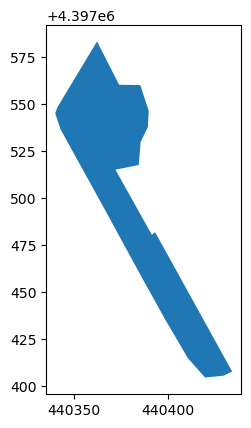

In [3]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 6)
single_land.plot()

split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  12
Num of Polygon lines:  20
Not on Convex:  11
Num of convex_hull:  7
Num of Polygon lines:  9
Not on Convex:  4


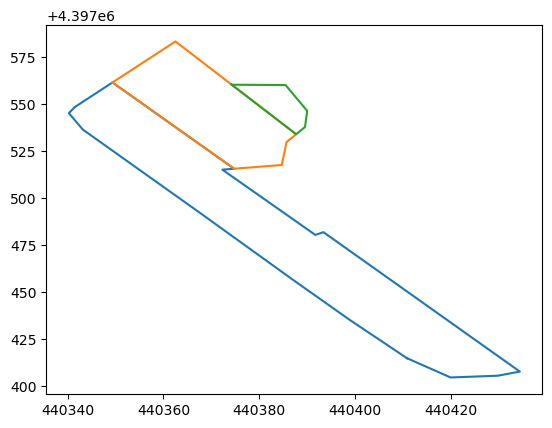

In [4]:
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.05)
_, ax = plt.subplots()
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy)

当前田块角度： 117.06086972480475


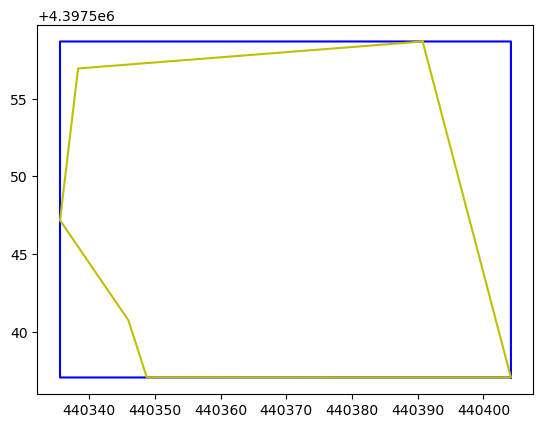

In [5]:
# 仅拿去其中的一个地块来测试耕作方向
single_polygon = split_polygon[1]
single_polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_polygon)
single_polygon = affinity.rotate(single_polygon, -single_polygon_angle, origin='centroid')
mabr = single_polygon.minimum_rotated_rectangle
_, ax = plt.subplots()
ax.plot(*mabr.exterior.xy, color='b')
ax.plot(*single_polygon.exterior.xy, color='y')

### 现在开始测试不实用 mabr 进行旋转，而是每一个方向，以 1度 为精度进行旋转计算所有方向下生成地头的耕作密度

In [6]:
corrected_swath_width = CPP_Planner_Kit.get_corrected_swath_width(swath_width=1.45, slope=6)
path, headland = CPP_Algorithms.scanline_algorithm_single_with_headland(
    land=gpd.GeoDataFrame(geometry=[single_polygon]), step_size=corrected_swath_width, along_long_edge=False,
    headland='left', head_land_width=6
)

0    MULTIPOLYGON (((440404.111 4397537.057, 440404...
dtype: geometry


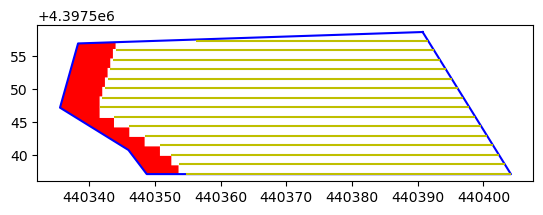

In [7]:
# 显示
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')
path.plot(ax=ax, color='y')
headland.plot(ax=ax, color='r')
print(headland)

In [8]:
diff_headland_direction_area = []
diff_path_direction_length = []
# 模拟旋转一周
for angle in range(0, 360):
    single_polygon = affinity.rotate(single_polygon, -1, origin='centroid')
    path, headland = CPP_Algorithms.scanline_algorithm_single_with_headland(
    land=gpd.GeoDataFrame(geometry=[single_polygon]), step_size=corrected_swath_width, along_long_edge=False,
    headland='left', head_land_width=6, get_largest_headland=False
    )
    diff_headland_direction_area.append(headland.geometry.area.item())

(Text(0.5, 0, 'direction'), Text(0, 0.5, 'area'))

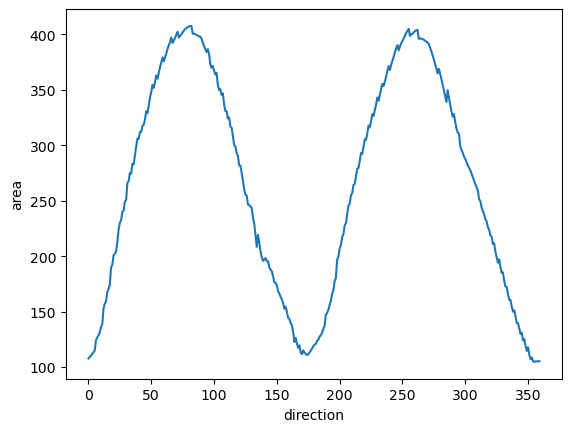

In [9]:
plt.plot(range(0, 360), diff_headland_direction_area)
plt.xlabel("direction"), plt.ylabel("area")

In [10]:
diff_headland_direction_area[0]

107.69412997541974

In [11]:
# 找到最小的面积区域
# type(diff_headland_direction_area[0].item())
# diff_headland_direction_area_2 = [i.item() for i in diff_headland_direction_area]
diff_headland_direction_area_2 = diff_headland_direction_area
min_area = min(diff_headland_direction_area_2)

In [12]:
# 找到最小面积区域的索引
min_area_index = diff_headland_direction_area_2.index(min_area)
print(min_area_index)

355


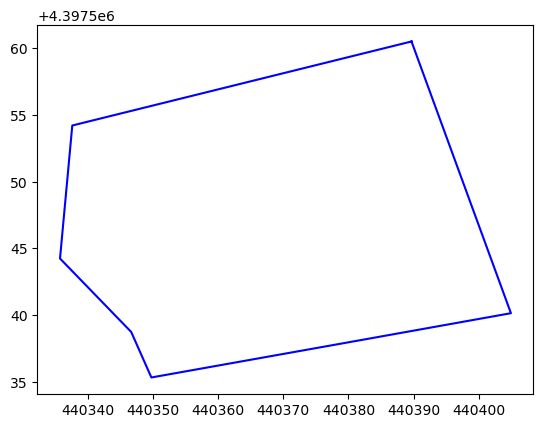

In [13]:
# 将几何图形旋转到最小面积区域的方向
single_polygon = affinity.rotate(single_polygon, -min_area_index, origin='centroid')
# show
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')

In [14]:
min_path, min_headland = CPP_Algorithms.scanline_algorithm_single_with_headland(
land=gpd.GeoDataFrame(geometry=[single_polygon]), step_size=corrected_swath_width, along_long_edge=False,
headland='left', head_land_width=6
)

<Axes: >

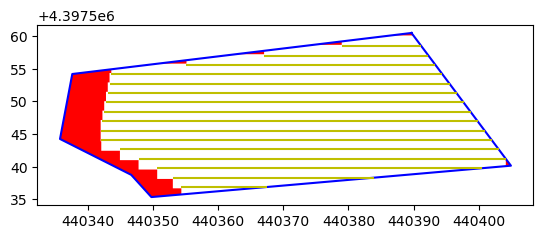

In [15]:
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')
min_path.plot(ax=ax, color='y')
min_headland.plot(ax=ax, color='r')

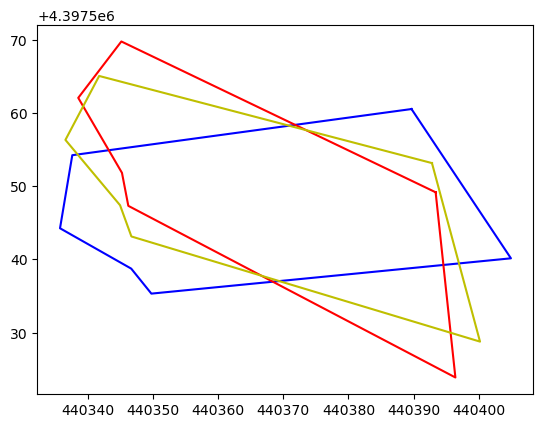

In [16]:
single_polygon_1 = affinity.rotate(single_polygon, -30)
single_polygon_2 = affinity.rotate(single_polygon, -20)
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')
ax.plot(*single_polygon_1.exterior.xy, 'r')
ax.plot(*single_polygon_2.exterior.xy, 'y')

In [17]:
single_polygon.area

1197.7512501213334